In [634]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet as wn
from nltk import pos_tag
import string
import re
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sn

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression

Problem Statement: Create a Text Classifier to be able to identify if the text splitter properly split the texts into proper segments. 

This first cell is to rename all the columns to proper names so it will make it simplier working with going forward and easier readability to any reader.

In [635]:
df = pd.read_excel('split_data.xlsx') #read excel file

split_count = max(df['splitCount'])    #max number of splits present in dataset

split_num = []

for i in range(split_count):    #creates column names for all the splits
    split_temp = 'splits' + str(i + 1)
    split_num.append(split_temp)
    
col_label = ['label','splitCount','originalStatement']  #first 3 columns

col_label.extend(split_num) 

df.columns = col_label     #renames columns to standard names

This is cell is to replace all the NaN with blank values. If the NaN are present later on when the model are to be ran it may change the weight of the statement that may only been split 4 times but will have value for all 12 splits.

In [636]:
df.replace(np.nan,'',inplace=True) #removes all NaN from the data
df

,label,splitCount,originalStatement,splits1,splits2,splits3,splits4,splits5,splits6,splits7,splits8,splits9,splits10,splits11,splits12
0,0,4,"peeing on the floor, hiding, scratching, meowing",Peeing on the floor,Meowing,Scratching,Hiding,,,,,,,,
1,0,2,it's part of the business. nothing unexpected,it's part of the business,Nothing unexpected,,,,,,,,,,
2,1,3,Cleans and conditions the skin,Cleans,The skin,Conditions,,,,,,,,,
3,1,2,Its greatt the US is leading in this.,Its greatt is leading in this,the US is leading in this,,,,,,,,,,
4,0,2,it is general statement and it could be done b...,It is general statement,It could be done by medical student,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,2,Knowing that I can get better rates and coverage.,Knowing that I can get better rates,Knowing that I can get coverage,,,,,,,,,,
496,1,12,im not sure and stuff and things and me and me...,Im,Me,Im you,Im me,Not sure,Im things,Things me,Im things you,Im things me,Im stuff,Stuff me,Im stuff you
497,0,2,Zero copays and lots of benefits.,Zero copays,Lots of benefits,,,,,,,,,,
498,0,2,purring and more affection,Purring,More affection,,,,,,,,,,


Tokenizer function that gives the option to the user to remove or keep stopwords, stem all the tokens, or lemmatize all the tokens. This will give the user greater variability to see what version will give the best results when the user trains the models. 

In [637]:
#tokenizer to tokenize, remove stopwords, stemmer, and lemmatizer all in one
def tokenizer(doc, stops= None, stemmer= None,lemmatization = None):
    try:
        doc = word_tokenize(doc.lower())
    except:
        doc = word_tokenize(str(doc))
    tokens = [''.join([char for char in tok if char not in string.punctuation]) for tok in doc]
    tokens = [tok for tok in tokens if tok]
    if stops:
        tokens = [tok for tok in tokens if (tok not in stops)]
    if stemmer:
        tokens = [stemmer.stem(tok) for tok in tokens]
    if lemmatization:
        tag_map = defaultdict(lambda : wn.NOUN)
        tag_map['J'] = wn.ADJ
        tag_map['V'] = wn.VERB
        tag_map['R'] = wn.ADV
                      
        tokens = [lemmatizer.lemmatize(token,tag_map[tag[0]]) for token,tag in pos_tag(tokens) if token not in stopwords]
    return tokens

In [638]:
#tokenizing all the words in the dataframe from originalStatement to final splits column
stopwords = set(nltk.corpus.stopwords.words('english')) 
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer(language='english')

for i in df.columns[2:]: 
    df[i] = [tokenizer(doc, stops = stopwords,lemmatization = None,stemmer=None) for doc in df[i].values.tolist()]

This cell will check for any special characters that are present with the strings and remove those rows from the dataframe. I orginally tried to use a language checker and nltk.wordnet however it would identify other words that were english that wasn't part of the predetermined vocabulary would of been included in the removal of the data. 

In [639]:
#check to see if words are properly encoded and removes words if they are not
drops = []
for index,words in enumerate(df['originalStatement']):
    for word in words:
        if len(word) != len(word.encode()):
            drops.append(index)

drops = list(set(drops))
df = df.drop(drops)

In [640]:
#returns each list of tokens of values back to single string
for i in df.columns[2:]:
    df[i] = [' '.join(word) for word in df[i].values.tolist()]

Count Vectorizer gives a unique key to each unique vocabulary word present in the dataframe. This will give a tally of how often each particular word is present in the strings a numerical value which then can be read by the models. I created a count vectorizer for unigram, bigram, and trigrams. The unigram is each word individually so will give presidence to individual key words that may have greater rate of determine a sentence. Next are bigrams which is a tuple of 2 words paired together, this can help give context to type of word pairs that might be in sentence formation. Finally are trigrams which is pairs of 3 words together. This will give greater context to the statement however with random phrases that are in the dataset that each statement is pretty unique it may not give as much insight as one would hope.

In [641]:
vectorizer = CountVectorizer()

In [642]:
# creates a list of arrays that are vectorized unigrams
vect_stack = []
for i in df.columns[2:]:
    if bool(re.match('split*',i)) != True:
        vect_stack.append(vectorizer.fit_transform(df[i].values.tolist()).toarray())
    else:
        vect_stack.append(vectorizer.transform(df[i].values.tolist()).toarray())


In [643]:
# takes the list of arrays and makes it into one array
x = np.stack(vect_stack,axis=1)

In [644]:
bi_vectorizer = CountVectorizer(ngram_range=(2,2))

In [645]:
# creates array of bigram vectors of data
bivect_stack = []
for i in df.columns[2:]:
    if bool(re.match('split*',i)) != True:
        bivect_stack.append(bi_vectorizer.fit_transform(df[i].values.tolist()).toarray())
    else:
        bivect_stack.append(bi_vectorizer.transform(df[i].values.tolist()).toarray())


In [646]:
# array of countvectorizer bigrams
x2 = np.stack(bivect_stack,axis=1)

In [647]:
tri_vectorizer = CountVectorizer(ngram_range=(3,3))

In [648]:
trivect_stack = []
for i in df.columns[2:]:
    if bool(re.match('split*',i)) != True:
        trivect_stack.append(tri_vectorizer.fit_transform(df[i].values.tolist()).toarray())
    else:
        trivect_stack.append(tri_vectorizer.transform(df[i].values.tolist()).toarray())


In [649]:
x4 = np.stack(trivect_stack,axis=1)

TF-IDF stands for Term Frequency - Inverse Document Frequency. It weights how often a word may show up in a particular document then offsets it value by how often may occur in other documents in the same corpus. So stopwords for example will show up in high frequency in the document being analyzed and it other documents so will be weighted lower while a word unique to said document that shows up multiple times will have a higher value. For this I also created unigram, bigrams, and trigrams which will give value to each row as its own 'document' and see in comparison to one another how they perform. 

In [650]:
tfidf_vectorizer = TfidfVectorizer()

In [651]:
#creats a list of arrays that are TF-IDF for unigrams
tfidf_stack = []

for i in df.columns[2:]:
    if bool(re.match('split*',i)) != True:
        tfidf_stack.append(tfidf_vectorizer.fit_transform(df[i].values.tolist()).toarray())
    else:
        tfidf_stack.append(tfidf_vectorizer.transform(df[i].values).toarray())

In [652]:
#takes the list of arrays from tfidf unigrams into singular array
x1 = np.stack(tfidf_stack,axis=1)

In [653]:
bi_tfidf_vectorizer = TfidfVectorizer(ngram_range=(2,2))

In [654]:
#creats a list of arrays that are TF-IDF for bigrams
bitfidf_stack = []

for i in df.columns[2:]:
    if bool(re.match('split*',i)) != True:
        bitfidf_stack.append(bi_tfidf_vectorizer.fit_transform(df[i].values.tolist()).toarray())
    else:
        bitfidf_stack.append(bi_tfidf_vectorizer.transform(df[i].values).toarray())

In [655]:
# array of tfidf values for bigrams
x3 = np.stack(bitfidf_stack,axis=1)

In [656]:
tri_tfidf_vectorizer = TfidfVectorizer(ngram_range=(3,3))

In [657]:
tritfidf_stack = []

for i in df.columns[2:]:
    if bool(re.match('split*',i)) != True:
        tritfidf_stack.append(tri_tfidf_vectorizer.fit_transform(df[i].values.tolist()).toarray())
    else:
        tritfidf_stack.append(tri_tfidf_vectorizer.transform(df[i].values).toarray())

In [658]:
x5 = np.stack(tritfidf_stack,axis=1)

In [659]:
y=df['label'].to_numpy()

In [851]:
# x = unigram count vectorizer, x1 = unigram tfidf, x2 = bigram counter vectorizer, x3 = bigram tfidf, 
# x4 = trigram count vectorizer, x5 = trigram tfidf
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=10)

From the stacking of all the individual row arrays into a single array resulted in a high dimensional array than the models are able to process. This led to me reshaping the arrays to 2D so the models would be able to read the data. The data is now just number of rows deep so for example there is 500 values in the array but each value in the array contains all 13 in my case different arrays combined into a single array. 

In [852]:
#reshapes the 3D array into 2D array for train dataset
nsamples, nx, ny = x_train.shape
d2_train_dataset = x_train.reshape((nsamples,nx*ny))

In [853]:
d2_train_dataset.shape

(363, 20150)

In [854]:
#reshapes the 3D array into 2D array for test dataset
nsamples1, nx1, ny1 = x_test.shape
d2_test_dataset = x_test.reshape((nsamples1,nx1*ny1)) 

Naive Bayes Model

In [730]:
gnb = GaussianNB()

In [731]:
gnb.fit(d2_train_dataset,y_train)

GaussianNB()

In [732]:
gnb.score(d2_test_dataset,y_test)

0.5819672131147541

In [733]:
y_pred = gnb.predict(d2_test_dataset)

In [734]:
f1_score(y_test, y_pred, average='macro')

0.5531135531135531

In [735]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[51, 27],
       [24, 20]], dtype=int64)

Text(0.5, 1.0, 'Gaussian Naive-Bayes Confusion Matrix')

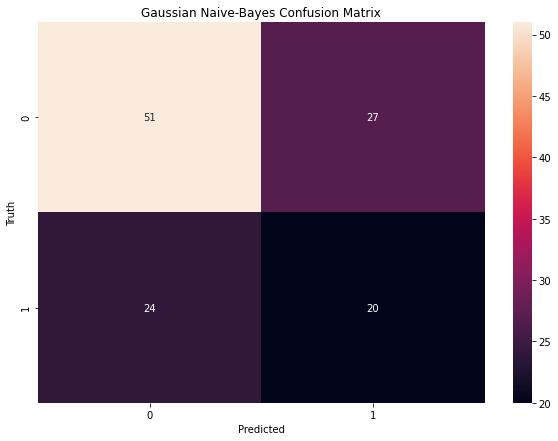

In [736]:
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Gaussian Naive-Bayes Confusion Matrix')

Precision = TP/(TP + FP)

Recall = TP / (TP + FN)

Recall can also be known as sensitivity

In [737]:
precision = cm[0][0] / (cm[0][0] + cm[1][0])
recall = cm[0][0] / (cm[0][0] + cm[0][1])
print('Precision = %.3f and Recall = %.3f' % (precision,recall))

Precision = 0.680 and Recall = 0.654


In [738]:
lr_probs = gnb.predict_proba(d2_test_dataset)
lr_probs = lr_probs[:, 0]

In [739]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, y_pred), auc(lr_recall, lr_precision)

In [740]:
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
no_skill = len(y_test[y_test==0]) / len(y_test)

Logistic: f1=0.440 auc=0.515


I decided to use Precision vs Recall as my choice to determine how the models performed as there was a larger value of one class outcome than the other. This can be seen by the No Skill line which would be how the model peformed if it guessed the strings were properly split for every case. The AUC (area under curve) score will help our understanding of how precision vs recall plays against each other. The predict_proba gives the probability of 0 being outputed at each step along the way of the recall vs precision curve.

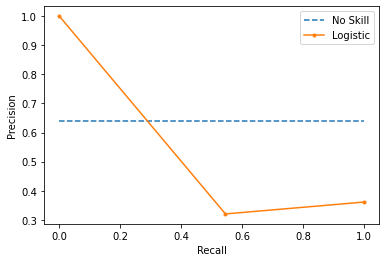

In [741]:
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

In [855]:
mnb = MultinomialNB(alpha=0.01)

In [856]:
mnb.fit(d2_train_dataset,y_train)

MultinomialNB(alpha=0.01)

In [857]:
mnb.score(d2_test_dataset,y_test)

0.6065573770491803

In [858]:
y_pred = mnb.predict(d2_test_dataset)

In [859]:
f1_score(y_test, y_pred, average='macro')

0.5878378378378377

In [860]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[50, 28],
       [20, 24]], dtype=int64)

Text(0.5, 1.0, 'Multinomial Naive-Bayes Confusion Matrix')

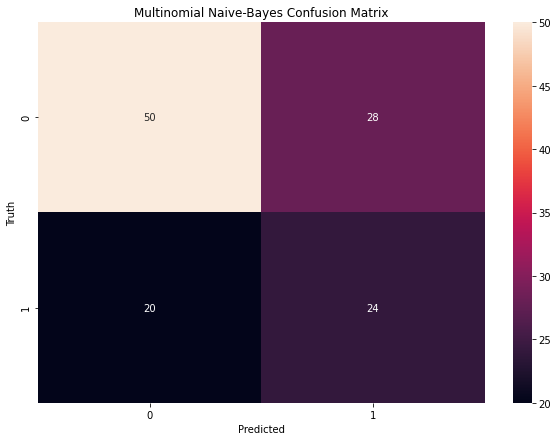

In [861]:
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Multinomial Naive-Bayes Confusion Matrix')

In [862]:
precision = cm[0][0] / (cm[0][0] + cm[1][0])
recall = cm[0][0] / (cm[0][0] + cm[0][1])
print('Precision = %.3f and Recall = %.3f' % (precision,recall))

Precision = 0.714 and Recall = 0.641


In [863]:
lr_probs = mnb.predict_proba(d2_test_dataset)
lr_probs = lr_probs[:, 0]

In [864]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, y_pred), auc(lr_recall, lr_precision)

In [865]:
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

Logistic: f1=0.500 auc=0.367


In [866]:
no_skill = len(y_test[y_test==0]) / len(y_test)

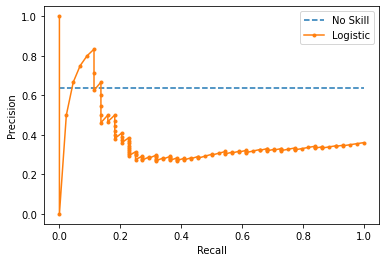

In [867]:
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

In [868]:
cnb = ComplementNB(alpha=0.01)

In [869]:
cnb.fit(d2_train_dataset,y_train)

ComplementNB(alpha=0.01)

In [870]:
cnb.score(d2_test_dataset,y_test)

0.5983606557377049

In [871]:
y_pred = cnb.predict(d2_test_dataset)

In [872]:
f1_score(y_test, y_pred, average='macro')

0.5835597352838733

In [873]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[48, 30],
       [19, 25]], dtype=int64)

Text(0.5, 1.0, 'Complement Naive-Bayes Confusion Matrix')

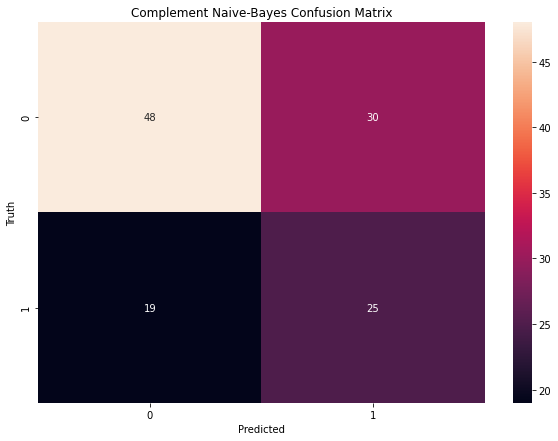

In [874]:
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Complement Naive-Bayes Confusion Matrix')

In [875]:
precision = cm[0][0] / (cm[0][0] + cm[1][0])
recall = cm[0][0] / (cm[0][0] + cm[0][1])
print('Precision = %.3f and Recall = %.3f' % (precision,recall))

Precision = 0.716 and Recall = 0.615


In [876]:
lr_probs = cnb.predict_proba(d2_test_dataset)
lr_probs = lr_probs[:, 0]

In [877]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, y_pred), auc(lr_recall, lr_precision)

In [878]:
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

Logistic: f1=0.505 auc=0.367


In [879]:
no_skill = len(y_test[y_test==0]) / len(y_test)

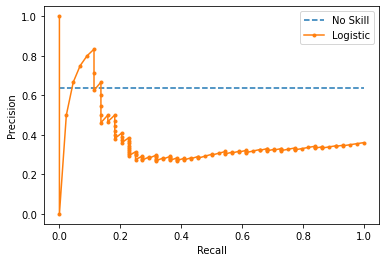

In [880]:
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

Random Forest Classifier

In [702]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(d2_train_dataset,y_train)

RandomForestClassifier()

In [703]:
clf.score(d2_test_dataset,y_test)

0.6639344262295082

In [704]:
y_pred = clf.predict(d2_test_dataset)

In [705]:
f1_score(y_test, y_pred, average='macro')

0.4597688735284588

In [706]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[78,  0],
       [41,  3]], dtype=int64)

Text(0.5, 1.0, 'Random Forest Classifier Confusion Matrix')

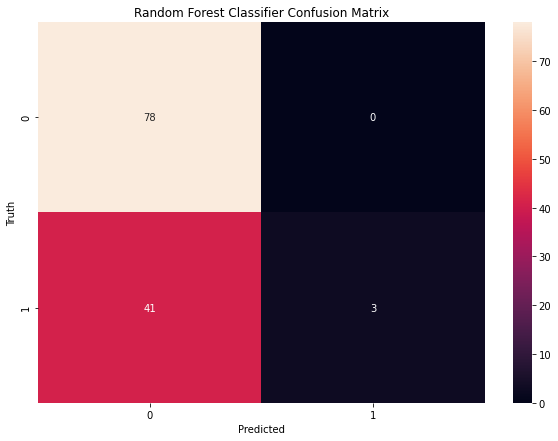

In [707]:
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Random Forest Classifier Confusion Matrix')

In [708]:
precision = cm[0][0] / (cm[0][0] + cm[1][0])
recall = cm[0][0] / (cm[0][0] + cm[0][1])
print('Precision = %.3f and Recall = %.3f' % (precision,recall))

Precision = 0.655 and Recall = 1.000


In [709]:
lr_probs = clf.predict_proba(d2_test_dataset)
lr_probs = lr_probs[:, 0]

In [710]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, y_pred), auc(lr_recall, lr_precision)
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

Logistic: f1=0.128 auc=0.326


In [711]:
no_skill = len(y_test[y_test==0]) / len(y_test)

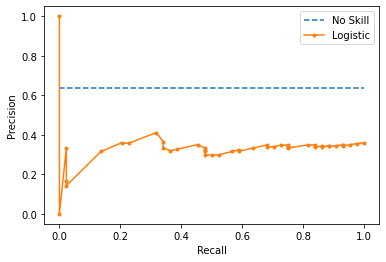

In [712]:
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

In [725]:
error

NameError: name 'error' is not defined

SVC Model

In [787]:
pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced',probability=True)
model = make_pipeline(pca, svc)

In [788]:
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

In [789]:
%time grid.fit(d2_train_dataset, y_train)
print(grid.best_params_)

Wall time: 1min 1s
{'svc__C': 1, 'svc__gamma': 0.001}


In [790]:
model = grid.best_estimator_
y_pred = model.predict(d2_test_dataset)

In [791]:
f1_score(y_test, y_pred, average='macro')

0.39

In [792]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[78,  0],
       [44,  0]], dtype=int64)

Text(0.5, 1.0, 'SVC Confusion Matrix')

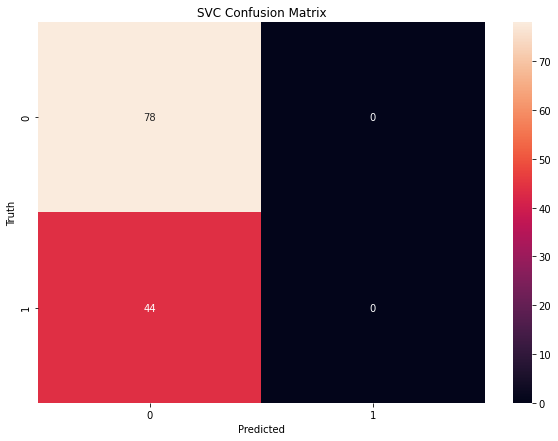

In [793]:
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('SVC Confusion Matrix')

In [794]:
precision = cm[0][0] / (cm[0][0] + cm[1][0])
recall = cm[0][0] / (cm[0][0] + cm[0][1])
print('Precision = %.3f and Recall = %.3f' % (precision,recall))

Precision = 0.639 and Recall = 1.000


In [795]:
lr_probs = model.predict_proba(d2_test_dataset)
lr_probs = lr_probs[:, 0]

In [796]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, y_pred), auc(lr_recall, lr_precision)
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

Logistic: f1=0.000 auc=0.318


In [797]:
no_skill = len(y_test[y_test==0]) / len(y_test)

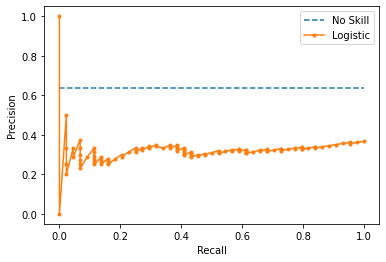

In [798]:
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()